In [1]:
import json
import pandas as pd
import re
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import cv2
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
)
from model import *

from tokenizers import Tokenizer
tokenizer = Tokenizer.from_file("tokenizer.json")

/Users/saptarshimallikthakur/Desktop/Extraas/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pad_id = tokenizer.encode('[PAD]').ids
unk_id = tokenizer.encode('[UNK]').ids
bos_id = tokenizer.encode('[BOS]').ids
eos_id = tokenizer.encode('[EOS]').ids
sep_id = tokenizer.encode('[SEP]').ids
img_token_id = tokenizer.encode('[IMG_TOKEN]').ids

In [3]:
class ParallelAdapterHead(tf.keras.layers.Layer):
    """
    A lightweight, trainable parallel head that learns to output a correction
    to the main decoder's logits.
    """
    def __init__(self, d_model, num_heads, vocab_size, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        
        # We can use your existing DecoderLayer blocks for the adapter!
        self.adapter_layers = DecoderLayer(d_model=d_model, num_heads=num_heads, dropout_rate=dropout_rate)
        
        # A final projection layer to get to the vocabulary size.
        # CRITICAL: Initialize weights to zero. This ensures that at the start of
        # training, the adapter outputs ~0 and doesn't disrupt the frozen decoder.
        self.to_logits = tf.keras.layers.Dense(
            vocab_size, 
            kernel_initializer='zeros', 
            use_bias=False, # Also good to have no bias or a zero-initialized bias
            name='adapter_final_projection'
        )

    def call(self, x, pad_mask=None, training=False):
        if pad_mask is not None:
            pad_mask = tf.cast(~pad_mask, tf.float32)[:, tf.newaxis, tf.newaxis, :]

        # Pass the input through the shallow adapter transformer layers
        x = self.adapter_layers(x, padding_mask=pad_mask, training=training)
        
        # Project to get the correction logits
        correction_logits = self.to_logits(x)
        return correction_logits

In [ ]:
def build_image_encoder(img_shape=(320, 320, 3)):
    """Builds a frozen MobileNetV3Small image encoder.

    Args:
        img_shape: Tuple of (height, width, channels) for input images.

    Returns:
        tf.keras.Model mapping images to feature sequences.
    """
    base = tf.keras.applications.MobileNetV3Small(
        input_shape=img_shape,
        weights=None,
        include_top=False,
        pooling=None
    )
    base.load_weights("weights_mobilenet_v3_small_224_1.0_float_no_top_v2.h5")
    base.trainable = False

    img_input = tf.keras.Input(shape=img_shape, dtype=tf.float32, name="image")
    feat_map = base(img_input, training=False)
    h, w, c = feat_map.shape[1], feat_map.shape[2], feat_map.shape[3]
    reshaped = tf.keras.layers.Reshape((h * w, c))(feat_map)
    return tf.keras.Model(img_input, reshaped, name="img_encoder")

def load_layer_weights(layer, input_shape, weights_path):
    """Loads weights into a custom layer by wrapping it in a temporary model.

    Args:
        layer: tf.keras.layers.Layer instance.
        input_shape: Tuple specifying the input shape for building the layer.
        weights_path: String, path to the weights (.weights.h5).

    Returns:
        The layer with loaded weights.
    """
    inputs = tf.keras.Input(shape=input_shape)
    outputs = layer(inputs)
    temp_model = tf.keras.Model(inputs, outputs)
    temp_model.load_weights(weights_path)
    return layer

class VLM(tf.keras.Model):
    """Vision-Language Model combining a pre-trained image encoder and language decoder.

    Args:
        vocab_size (int): Vocabulary size for token embeddings and output projection.
        d_model (int): Embedding dimension.
        num_layers (int): Number of decoder layers.
        num_heads (int): Number of attention heads.
        img_shape: Tuple of (height, width, channels) for input images.
        dropout_rate (float, optional): Dropout rate. Defaults to 0.1.
    """
    def __init__(self, *, vocab_size, d_model, num_layers, num_heads, img_shape=(320, 320, 3), dropout_rate=0.1, pad_token_id = pad_id):
        super().__init__()
        self.pad_token_id = pad_token_id
        self.token_embedding = TokenEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.decoder = Decoder(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            input_vocab_size=vocab_size,
            dropout_rate=dropout_rate
        )
        self.img_embedding = build_image_encoder(img_shape)
        self.dense = tf.keras.Sequential([
            tf.keras.layers.LayerNormalization(epsilon=1e-5),
            tf.keras.layers.Dense(d_model*2, activation='gelu'),
            tf.keras.layers.Dropout(0.01),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(0.01)
            ])
        
        self.adapter_head = ParallelAdapterHead(
            d_model=d_model, 
            num_heads=2*num_heads, 
            vocab_size=vocab_size
        )

        self.img_seq_len = self.img_embedding.output_shape[1]  # e.g., 100 for 10x10 feature map
        self.d_model = d_model
        self.token_embedding.trainable = False
        self.decoder.trainable = False

    def load_pretrained_weights(self, token_emb_path, decoder_path):
        """Loads pre-trained weights for token embedding and decoder.

        Args:
            token_emb_path: Path to token embedding weights (.weights.h5).
            decoder_path: Path to decoder weights (.weights.h5).
        """
        self.token_embedding = load_layer_weights(self.token_embedding, (None,), token_emb_path)
        self.decoder = load_layer_weights(self.decoder, (None, self.d_model), decoder_path)

    def call(self, inputs, training=False):
        """Processes images and tokens to generate output logits.

        Args:
            inputs: Tuple of (images, tokens), where:
                - images: Tensor of shape (batch_size, height, width, channels).
                - tokens: Tensor of shape (batch_size, sequence_length) with token indices.
            training: Boolean indicating training or inference mode.

        Returns:
            Tensor of shape (batch_size, img_seq_len + sequence_length, vocab_size) with logits.
        """
        images, tokens = inputs
        full_mask = self.token_embedding.compute_mask(tokens)

        img_emb = self.img_embedding(images, training=False)
        img_emb = self.dense(img_emb, training=training)

        text_emb = self.token_embedding(tokens, training=False)
        x = tf.concat([img_emb, text_emb[:, self.img_seq_len:, :]], axis=1)

        frozen_logits = self.decoder(x, pad_mask=full_mask, training=False)
        correction_logits = self.adapter_head(x, pad_mask=full_mask, training=training)
        return frozen_logits + correction_logits

In [5]:
# Open and read the JSON file  https://huggingface.co/datasets/liuhaotian/LLaVA-Pretrain
with open("/Users/saptarshimallikthakur/Desktop/Extraas/Towards VLM/VLM/blip images/blip_laion_cc_sbu_558k.json", "r") as file:
    data = json.load(file)  # Parse the JSON data into a Python dictionary

# Convert to DataFrame
df3 = pd.DataFrame([{
    'id': item['id'],
    'img_path': '/Users/saptarshimallikthakur/Desktop/Extraas/Towards VLM/VLM/blip images/images/'+item['image'],
    'input_text': next(conv['value'] for conv in item['conversations'] if conv['from'] == 'human'),
    'target_text': next(conv['value'] for conv in item['conversations'] if conv['from'] == 'gpt')
} for item in data]).dropna().reset_index(drop=True)

df3['input_text'] = None

question_pool = [
    'Render a clear and concise summary of the photo.\n<image>',
    'Write a terse but informative summary of the picture.\n<image>',
    '<image>\nWhat is this?',
    '<image>\nRender a clear and concise summary of the photo.',
    'What is in the photo?\n<image>',
    'Describe the image concisely.\n<image>',
    'Share a concise interpretation of the image provided.\n<image>',
    'Give a brief description of the image.\n<image>',
    "<image>\nPresent a compact description of the photo's key features.",
    '<image>\nDescribe the image concisely.', 'What is this?\n<image>',
    '<image>\nWrite a terse but informative summary of the picture.',
    'Provide a brief description of the given image.\n<image>',
    'Summarize the visual content of the image.\n<image>',
    '<image>\nWhat is in the photo?',
    '<image>\nProvide a brief description of the given image.',
    "Present a compact description of the photo's key features.\n<image>",
    'Give a short and clear explanation of the subsequent image.\n<image>',
    '<image>\nGive a short and clear explanation of the subsequent image.',
    '<image>\nGive a brief description of the image.',
    '<image>\nSummarize the visual content of the image.',
    '<image>\nShare a concise interpretation of the image provided.'
    "What is present in the image?",
    "How would you describe the background setting?",
    "What is the central subject or point of focus?",
    "What is happening in the image?",
    "Where might this photo have been taken?",
    "Describe the image.",
    "Are there people in the picture?",
    "Is there an animal in the picture?",
    "What objects are visible in the image?",
    "What activity or event is occurring in the image?",
    "Can you describe the colors present in the image?",
    "What do you think the mood or atmosphere of the image is?",
    "What draws your attention most in the image?",
    "Does the image appear to be candid or posed?",
    "Is there any text or signage visible in the image?",
    "Are there any buildings or structures visible?",
    "Does the image convey any emotions or feelings?",
    "Are there any artistic or stylistic elements in the photo?",
    "If you could give this image a title, what would it be?",
    'What is unique about the image?',
]

# Assign questions per img_path group
for img_path, group in df3.groupby('img_path'):
    indices = group.index.tolist()
    available_questions = question_pool.copy()
    np.random.shuffle(available_questions)
    
    # If more rows than questions, cycle through questions
    while len(available_questions) < len(indices):
        extra = question_pool.copy()
        np.random.shuffle(extra)
        available_questions += extra

    for i, idx in enumerate(indices):
        df3.at[idx, 'input_text'] = available_questions[i]
df3 = df3[['img_path','target_text','input_text']]
df3

img_path  \
0       /Users/saptarshimallikthakur/Desktop/Extraas/T...   
1       /Users/saptarshimallikthakur/Desktop/Extraas/T...   
2       /Users/saptarshimallikthakur/Desktop/Extraas/T...   
3       /Users/saptarshimallikthakur/Desktop/Extraas/T...   
4       /Users/saptarshimallikthakur/Desktop/Extraas/T...   
...                                                   ...   
558123  /Users/saptarshimallikthakur/Desktop/Extraas/T...   
558124  /Users/saptarshimallikthakur/Desktop/Extraas/T...   
558125  /Users/saptarshimallikthakur/Desktop/Extraas/T...   
558126  /Users/saptarshimallikthakur/Desktop/Extraas/T...   
558127  /Users/saptarshimallikthakur/Desktop/Extraas/T...   

                                              target_text  \
0       select luxury furniture 3 - inch gel memory fo...   
1                   a grey watch with an army style strap   
2       a dragon kite flying in the blue sky stock images   
3       $ 10 - cute cheap printed mini dress - khaki m...   
4         augmented reality using aruco markers in opencv   
...                                                   ...   
558123  paper quilled letters of the alphabet h with c...   
558124  a jabra corded headset with usb sync, power co...   
558125  an apple ii computer, with a computer monitor ...   
558126  us03498792 figure 1 from a patent drawing of a...   
558127            how to draw odin from vikings - step 11   

                                               input_text  
0          Are there any buildings or structures visible?  
1                                  <image>\nWhat is this?  
2                          <image>\nWhat is in the photo?  
3       <image>\nProvide a brief description of the gi...  
4          What is the central subject or point of focus?  
...                                                   ...  
558123                             What is this?\n<image>  
558124             <image>\nDescribe the image concisely.  
558125  Give a short and clear explanation of the subs...  
558126                                Describe the image.  
558127  Render a clear and concise summary of the phot...  

[558128 rows x 3 columns]

In [6]:
with open('/Users/saptarshimallikthakur/Desktop/Extraas/Towards VLM/VLM/fsvqa/fsvqa_original/fsvqa_original_train_questions.json', 'r') as f:
    data = json.load(f)

# 'questions' is expected to be a list of dictionaries
questions = data['questions']

# Convert list of dicts to DataFrame
df1 = pd.DataFrame(questions)[['img_id', 'question', 'question_id']]
df1.reset_index(drop=True, inplace=True)

# Step 1: Load the raw JSON structure
with open('/Users/saptarshimallikthakur/Desktop/Extraas/Towards VLM/VLM/fsvqa/fsvqa_original/fsvqa_original_train_annotations.json', 'r') as f:
    data = json.load(f)

# Step 2: Extract the list of annotation dicts
annotations = data['annotations']  # each item contains 'question_id' and 'answers'

# Step 3: Flatten the data
# Each annotation contains a list of 'answers', so we need to explode that
flat_data = []
for ann in annotations:
    question_id = ann['question_id']
    img_id = ann['img_id']
    for ans in ann['answers']:
        flat_data.append({
            'question_id': question_id,
            'img_id': img_id,
            'answer': ans['answer']
        })

# Step 4: Convert to DataFrame
df2 = pd.DataFrame(flat_data)

# Optional: Reset index and show a few rows
df2.reset_index(drop=True, inplace=True)

df4 = pd.merge(df1,df2,how='left',on='question_id').drop(columns=['img_id_y']).rename(columns={'img_id_x': 'img_id'})
df4 = df4.sort_values(by='img_id').reset_index(drop=True)[['img_id','question','answer']]
df4['img_id'] = df4['img_id'].apply(lambda x: '/Users/saptarshimallikthakur/Desktop/Extraas/Towards VLM/VLM/fsvqa/train2014/'+str(x)+'.jpg')
df4 = df4.rename(columns={'img_id':'img_path','question':'input_text','answer':'target_text'})
df4

img_path  \
0       /Users/saptarshimallikthakur/Desktop/Extraas/T...   
1       /Users/saptarshimallikthakur/Desktop/Extraas/T...   
2       /Users/saptarshimallikthakur/Desktop/Extraas/T...   
3       /Users/saptarshimallikthakur/Desktop/Extraas/T...   
4       /Users/saptarshimallikthakur/Desktop/Extraas/T...   
...                                                   ...   
248344  /Users/saptarshimallikthakur/Desktop/Extraas/T...   
248345  /Users/saptarshimallikthakur/Desktop/Extraas/T...   
248346  /Users/saptarshimallikthakur/Desktop/Extraas/T...   
248347  /Users/saptarshimallikthakur/Desktop/Extraas/T...   
248348  /Users/saptarshimallikthakur/Desktop/Extraas/T...   

                                    input_text  \
0                     What is the green stuff?   
1                How many cookies can be seen?   
2                   What color are the dishes?   
3                  Are both giraffes standing?   
4                        Where is the giraffe?   
...                                        ...   
248344              Is this boat in the water?   
248345                 Are there storm clouds?   
248346                       Is the snow deep?   
248347    Is there a lot of snow on the floor?   
248348  What sport is being demonstrated here?   

                                      target_text  
0                    The green stuff is broccoli.  
1                          2 cookies can be seen.  
2                 The dishes are pink and yellow.  
3             No, both giraffes are not standing.  
4                    The giraffe is at near tree.  
...                                           ...  
248344         No, this boat is not in the water.  
248345               Yes, there are storm clouds.  
248346                     Yes, the snow is deep.  
248347  Yes, there is a lot of snow on the floor.  
248348   Snowboarding is being demonstrated here.  

[248349 rows x 3 columns]

In [7]:
# df = pd.concat([df12,df3,df4])[['input_text','target_text','img_path']].reset_index(drop=True)
df = pd.concat([df3,df4])[['input_text','target_text','img_path']].reset_index(drop=True)
del(df1)
del(df2)
del(df3)
# del(df12)
del(df4)
df

input_text  \
0          Are there any buildings or structures visible?   
1                                  <image>\nWhat is this?   
2                          <image>\nWhat is in the photo?   
3       <image>\nProvide a brief description of the gi...   
4          What is the central subject or point of focus?   
...                                                   ...   
806472                         Is this boat in the water?   
806473                            Are there storm clouds?   
806474                                  Is the snow deep?   
806475               Is there a lot of snow on the floor?   
806476             What sport is being demonstrated here?   

                                              target_text  \
0       select luxury furniture 3 - inch gel memory fo...   
1                   a grey watch with an army style strap   
2       a dragon kite flying in the blue sky stock images   
3       $ 10 - cute cheap printed mini dress - khaki m...   
4         augmented reality using aruco markers in opencv   
...                                                   ...   
806472                 No, this boat is not in the water.   
806473                       Yes, there are storm clouds.   
806474                             Yes, the snow is deep.   
806475          Yes, there is a lot of snow on the floor.   
806476           Snowboarding is being demonstrated here.   

                                                 img_path  
0       /Users/saptarshimallikthakur/Desktop/Extraas/T...  
1       /Users/saptarshimallikthakur/Desktop/Extraas/T...  
2       /Users/saptarshimallikthakur/Desktop/Extraas/T...  
3       /Users/saptarshimallikthakur/Desktop/Extraas/T...  
4       /Users/saptarshimallikthakur/Desktop/Extraas/T...  
...                                                   ...  
806472  /Users/saptarshimallikthakur/Desktop/Extraas/T...  
806473  /Users/saptarshimallikthakur/Desktop/Extraas/T...  
806474  /Users/saptarshimallikthakur/Desktop/Extraas/T...  
806475  /Users/saptarshimallikthakur/Desktop/Extraas/T...  
806476  /Users/saptarshimallikthakur/Desktop/Extraas/T...  

[806477 rows x 3 columns]

In [8]:
# 1) Text cleaning ------------------------------------------------------
def clean_text(text: str) -> str:
    """
    Remove HTML, normalize whitespace, preserve punctuation/numbers/casing.
    """
    # text = text.lower()
    text = re.sub(r'<image>', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^a-zA-Z0-9.,!?]+', ' ', text)
    text = text.replace('\r', ' ').replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

df['target_text'] = df['target_text'].apply(lambda x: clean_text(x))
df['input_text'] = df['input_text'].apply(lambda x: clean_text(x))

100%|██████████| 806477/806477 [00:22<00:00, 35734.13it/s]


Total samples    : 806,477
Min / Max tokens : 6 / 118
Mean ± std       : 24.9 ± 9.1
--- percentiles (tokens) ---
 50% : 24
 90% : 37
 95% : 41
 98% : 46
 99% : 49


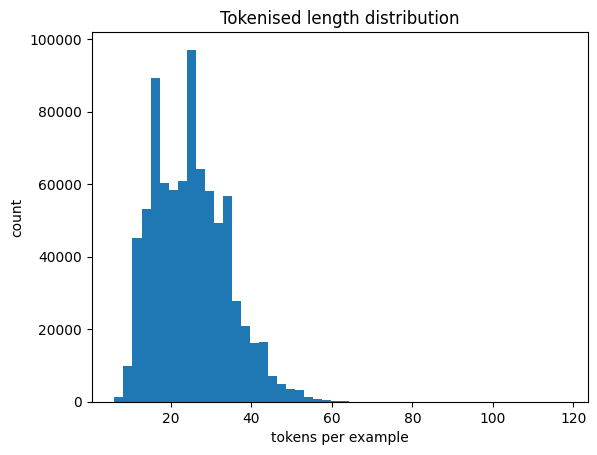

In [9]:
# 0)  Make sure `tok` points to the FINAL tokenizer
#     → trained on the full corpus with your chosen vocab_size
# ------------------------------------------------------------
tok = tokenizer          # whatever variable you use

# ------------------------------------------------------------
# 1)  Get token counts for every example
#     (here: concatenate summary + dialogue; split if you want)
# ------------------------------------------------------------
lens = []

for s, d in tqdm(zip(df["input_text"], df["target_text"]),
                 total=len(df)):
    iids   = tok.encode(s).ids
    tids   = tok.encode(d).ids
    
    lens.append(len(iids+tids))

lens = np.array(lens)

# ------------------------------------------------------------
# 2)  Print key stats
# ------------------------------------------------------------
def pct(x): return np.percentile(lens, x)

print(f"Total samples    : {len(lens):,}")
print(f"Min / Max tokens : {lens.min()} / {lens.max()}")
print(f"Mean ± std       : {lens.mean():.1f} ± {lens.std():.1f}")
print("--- percentiles (tokens) ---")
for p in (50, 90, 95, 98, 99):
    print(f"{p:>3}% : {pct(p):.0f}")

# ------------------------------------------------------------
# 3)  Quick histogram    (no seaborn, single plot, no colors set)
# ------------------------------------------------------------
plt.hist(lens, bins=50)
plt.xlabel("tokens per example")
plt.ylabel("count")
plt.title("Tokenised length distribution")
plt.show()

In [10]:
# Configuration
VOCAB_SIZE = 4000
MAX_LEN = 100+int(pct(99))+1
BATCH_SIZE = 32
num_layers = 2
d_model = 256
num_heads = 8
dropout_rate = 0.1
IMG_SHAPE = (320, 320, 3)

# Build and load VLM
vlm = VLM(
    vocab_size=VOCAB_SIZE,
    d_model=d_model,
    num_layers=num_layers,
    num_heads=num_heads,
    img_shape=IMG_SHAPE,
    dropout_rate=dropout_rate
)

# Load pre-trained weights
vlm.load_pretrained_weights(
    token_emb_path="token_embedding_weights.weights.h5",
    decoder_path="decoder_weights.weights.h5"
)

# Build weights with dummy input
def decode_and_resize(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SHAPE[:2])
    return img

dummy_path = tf.constant(["/Users/saptarshimallikthakur/Desktop/New Folder With Items/cars3.jpg"])
images = tf.map_fn(decode_and_resize, dummy_path, fn_output_signature=tf.float32)
dummy_tokens = tf.zeros((1, MAX_LEN), dtype=tf.int32)
_ = vlm((images, dummy_tokens))
vlm.summary()

2025-07-22 15:37:11.584913: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-07-22 15:37:11.584944: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-07-22 15:37:11.584952: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1753178831.584967 3324832 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753178831.584992 3324832 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vlm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ token_embedding                 │ (None, None, 256)      │     1,024,000 │
│ (TokenEmbedding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ (None, None, 4000)     │     2,340,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ img_encoder (Functional)        │ (None, 100, 576)       │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (1, 100, 256)          │       427,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ parallel_adapter_head           │ ?                      │     1,679,872 │
│ (ParallelAdapterHead)           │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,410,896 (24.46 MB)

 Trainable params: 2,107,776 (8.04 MB)

 Non-trainable params: 4,303,120 (16.42 MB)

In [11]:
text_pairs = []

for img,i,j in zip(df.img_path,df.input_text,df.target_text):
    text_pairs.append((img,i,j))

len(text_pairs), text_pairs[:5]

(806477,
 [('/Users/saptarshimallikthakur/Desktop/Extraas/Towards VLM/VLM/blip images/images/00453/004539375.jpg',
   'are there any buildings or structures visible?',
   'select luxury furniture 3 inch gel memory foam mattress topper'),
  ('/Users/saptarshimallikthakur/Desktop/Extraas/Towards VLM/VLM/blip images/images/00223/002239345.jpg',
   'what is this?',
   'a grey watch with an army style strap'),
  ('/Users/saptarshimallikthakur/Desktop/Extraas/Towards VLM/VLM/blip images/images/00594/005947502.jpg',
   'what is in the photo?',
   'a dragon kite flying in the blue sky stock images'),
  ('/Users/saptarshimallikthakur/Desktop/Extraas/Towards VLM/VLM/blip images/images/00511/005116462.jpg',
   'provide a brief description of the given image.',
   '10 cute cheap printed mini dress khaki multicolor striped floral print peasant short sleeve tunic'),
  ('/Users/saptarshimallikthakur/Desktop/Extraas/Towards VLM/VLM/blip images/images/00201/002017886.jpg',
   'what is the central subje

In [12]:
# 1) encode_pair → return a NumPy array
def encode_pair(text_a: str, text_b: str) -> np.ndarray:
    enc = img_token_id*100 + bos_id + tokenizer.encode(text_a).ids + sep_id + tokenizer.encode(text_b).ids + eos_id
    enc = enc[:MAX_LEN]
    enc = enc + pad_id*(MAX_LEN-len(enc))
    return np.array(enc, dtype=np.int32)   # shape: [MAX_LEN]

def encode_example(img_path, text: str, summary: str):
    ids = encode_pair(text, summary)           # np.ndarray, shape=[MAX_LEN]
    labels = np.concatenate([ids[1:], np.array(pad_id)])  # shape=[MAX_LEN]

    # find BOS
    BOS_idxs = np.where(labels == bos_id)[0]
    BOS_pos = int(BOS_idxs[0]) if BOS_idxs.size else len(ids)

    # build base mask: 1 only for positions > sep_pos AND not PAD
    positions = np.arange(len(labels))
    loss_mask = (positions > BOS_pos).astype(np.float32) * (labels != pad_id).astype(np.float32)

    return img_path, ids, labels.astype(np.int32), loss_mask

# ── 0. do *all* tokenisation once ──────────────────────────
triples = [encode_example(img, t, s) for (img, t, s) in text_pairs]   # Python loop, done **once**
img_path, ids, labels, masks = map(lambda k: tf.constant(np.stack(k, 0)),zip(*triples))                      # shapes [N, MAX_LEN]

# ── 1. build the purely-TF dataset ─────────────────────────
ds = (
    tf.data.Dataset.from_tensor_slices({'img_path':img_path,"input_ids": ids, "labels": labels, "loss_mask": masks})
    .shuffle(len(text_pairs))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

del(triples)
del(img_path)
del(ids)
del(labels)
del(masks)

In [13]:
vocab = tokenizer.get_vocab()           # indices 0 … V

id_to_token = {idx: tok for tok, idx in vocab.items()}

# 2) Decoder: drop PADs
def decode_token_ids(token_ids: list[int]) -> str:
    tokens = []
    for tid in token_ids:
        if tid == pad_id:
            continue
        tok = id_to_token.get(tid, '?')
        if tok == '$':
            continue  # Skip the '$' symbol
        if tok.startswith('Ġ'):
            tok = tok[1:]  # Remove the space prefix indicator
            tokens.append(' ' + tok)
        else:
            tokens.append(tok)
    return ' '.join(tokens).strip()

# 3) Inspect one batch from your TF dataset
for batch in ds.take(10):
    pth = batch['img_path'].numpy()
    input_ids = batch['input_ids'].numpy()  # shape (batch, MAX_LEN)
    labels    = batch['labels'].numpy()

    for i, (pth, ids_row, lbl_row) in enumerate(zip(pth, input_ids, labels), start=1):
        print(f"\n🟢 Sample {i}")
        print("  pth: ", pth)
        print("  Input IDs: ", ids_row.tolist())
        print("  Decoded:   ", decode_token_ids(ids_row.tolist()))
        print("  Label IDs: ", lbl_row.tolist())


🟢 Sample 1
  pth:  b'/Users/saptarshimallikthakur/Desktop/Extraas/Towards VLM/VLM/blip images/images/00063/000639141.jpg'
  Input IDs:  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 686, 34, 1496, 38, 39, 1492, 2516, 518, 459, 126, 72, 3688, 18, 4, 72, 1427, 3706, 42, 49, 22, 20, 16, 34, 2398, 1767, 1489, 161, 72, 2298, 16, 93, 3066, 404, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  Decoded:    [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [I

2025-07-22 15:37:54.865955: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
for batch in ds.take(1):
    input_ids = batch["input_ids"]
    labels    = batch["labels"]
    loss_mask = batch["loss_mask"]
    
j=19
print(loss_mask[j][90:130])
print(input_ids[j][90:130])
print(labels[j][90:130])

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(40,), dtype=float32)
tf.Tensor(
[   5    5    5    5    5    5    5    5    5    5    2  326  157  208
  686  403 3688   34   53   78   90   16  259  264   78  107   33    4
   34 3673  126 3347  617    3    0    0    0    0    0    0], shape=(40,), dtype=int32)
tf.Tensor(
[   5    5    5    5    5    5    5    5    5    2  326  157  208  686
  403 3688   34   53   78   90   16  259  264   78  107   33    4   34
 3673  126 3347  617    3    0    0    0    0    0    0    0], shape=(40,), dtype=int32)


2025-07-22 15:37:56.426247: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
WARM_FRAC   = 0.1      # keep the fast ramp-up
DECAY_RATE  = 4
LR_FLOOR    = 1e-6
LR_PEAK_DESIRED = 1e-4     
EPOCHS = 3

# pre-compute the scale that gives that peak
num_steps     = EPOCHS * len(text_pairs) // BATCH_SIZE
warmup_steps  = int(num_steps * WARM_FRAC)
current_peak  = 1.0 / tf.sqrt(tf.cast(d_model * warmup_steps, tf.float32))
LR_SCALE      = LR_PEAK_DESIRED / current_peak.numpy()

@tf.keras.utils.register_keras_serializable()   # so it can round-trip in SavedModel/H5
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, total_steps=num_steps,
                 warmup_frac=WARM_FRAC, decay_rate=DECAY_RATE,
                 lr_scale=LR_SCALE):
        super().__init__()
        self.d_model      = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(int(total_steps * warmup_frac), tf.float32)
        self.decay_rate   = decay_rate
        self.decay_steps  = tf.cast(total_steps, tf.float32)
        self.lr_scale     = tf.cast(lr_scale, tf.float32)

    def __call__(self, step):
        step  = tf.cast(step, tf.float32)
        arg1  = tf.math.rsqrt(step)
        arg2  = step * tf.math.pow(self.warmup_steps, -1.5)
        warm  = tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
        decay = tf.math.exp(-self.decay_rate *
                            tf.maximum(step - self.warmup_steps, 0.) /
                            self.decay_steps)
        lr = warm * decay * self.lr_scale 
        return tf.maximum(lr, LR_FLOOR)

    # ----------  NEW  ----------
    def get_config(self):
        return {
            "d_model":      int(self.d_model.numpy()),   # cast back to Python types
            "total_steps":  int(self.decay_steps.numpy()),
            "warmup_frac":  float(self.warmup_steps.numpy() / self.decay_steps.numpy()),
            "decay_rate":   self.decay_rate,
            "lr_scale":     float(self.lr_scale.numpy()),
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9, clipnorm=1.0)

In [16]:
ds_for_fit = ds.map(
    lambda b: (
        (tf.map_fn(decode_and_resize, b['img_path'], fn_output_signature=tf.float32), b["input_ids"]),
        b["labels"],
        b["loss_mask"]
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)

# 3) Compile with a standard sparse‐CE loss and let Keras use sample weights
vlm.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="mean_with_sample_weight"),
    metrics=["sparse_categorical_accuracy"]
)


# 4) Fit!  Keras will print epoch/step progress by default
history = vlm.fit(
    ds_for_fit,
    epochs=EPOCHS,
    verbose=1    # 1 = progress bar, loss & acc per epoch
)

Epoch 1/3


2025-07-22 15:37:58.901583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


   55/25203 ━━━━━━━━━━━━━━━━━━━━ 1:57:16 280ms/step - loss: 8.4965 - sparse_categorical_accuracy: 0.0066

KeyboardInterrupt: 

In [ ]:
def encode(text: str) -> list[int]:
    """
    Encodes the prompt for inference, creating a sequence that ends
    right after the [SEP] token, with NO PADDING.
    """

    # 1. Encode the text. The post-processor will add [BOS] and [SEP].
    # This will return: [BOS, id, id, ..., SEP]
    text_ids = bos_id + tokenizer.encode(text).ids + sep_id
    
    # 2. Prepend the image placeholder tokens
    full_ids = img_token_id * 100 + text_ids

    return full_ids

def generate_answer(image_path: str,
                    question:   str,
                    max_new_tokens: int = 30) -> str:
    
    img_token = tf.constant([image_path])
    img_token = tf.map_fn(decode_and_resize, img_token, fn_output_signature=tf.float32)
    
    # 1. Encode the prompt (image placeholders + question)
    # This creates: [IMG]...[IMG] [BOS] question [SEP]
    prompt_ids = encode(clean_text(question))
    text_tokens = tf.constant([prompt_ids], dtype=tf.int32)
    
    # 2. Autoregressive loop
    for _ in range(max_new_tokens):
        # Use direct model call for performance (not model.predict)
        # Pass training=False
        logits = vlm((img_token, text_tokens), training=False)[:, -1, :] / 0.1
        
        # Sample the next token
        next_id = tf.random.categorical(logits, 1, dtype=tf.int32)

        # Append the new token
        text_tokens = tf.concat([text_tokens, next_id], 1)

        # Stop ONLY if EOS is generated
        if next_id[0, 0] == eos_id:
            break

    # 3. Decode the generated output
    generated_ids = text_tokens.numpy().tolist()[0] 

    print(generated_ids)
    
    # --- END FIX ---

    # Display image for context
    imgbgr = cv2.imread(image_path)
    if imgbgr is not None:
        imgrgb = cv2.cvtColor(imgbgr,cv2.COLOR_BGR2RGB)
        plt.imshow(imgrgb)
        plt.title(f"Q: {question}")
        plt.axis('off')
        plt.show()

    print(tokenizer.decode(generated_ids).strip())

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 259, 200, 157, 311, 33, 4, 72, 1436, 18, 3]


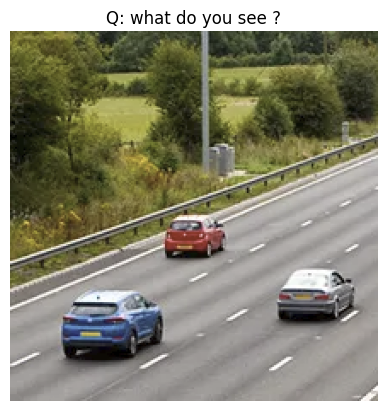

what do you see ? the cars .
None


In [ ]:
img   =  "/Users/saptarshimallikthakur/Desktop/New Folder With Items/Screenshot 2025-07-17 at 5.42.35 AM.png"
ques  = "what do you see ?"
print(generate_answer(img, ques))

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 415, 623, 436, 200, 157, 311, 33, 4, 42, 311, 299, 22, 2678, 18, 3]


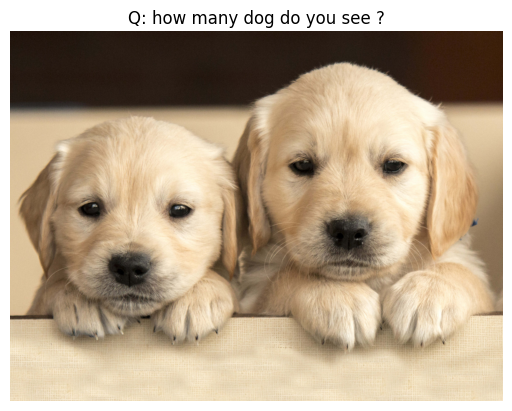

how many dog do you see ? i see are 2 dogs .
None


In [ ]:
img   =  "/Users/saptarshimallikthakur/Desktop/New Folder With Items/cutest-dog-breeds-jpg.jpg"
ques  = "how many dog do you see ?"
print(generate_answer(img, ques))

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 686, 34, 1496, 38, 39, 1492, 2516, 518, 459, 126, 72, 3688, 18, 4, 34, 271, 76, 34, 1404, 76, 34, 2517, 1404, 3]


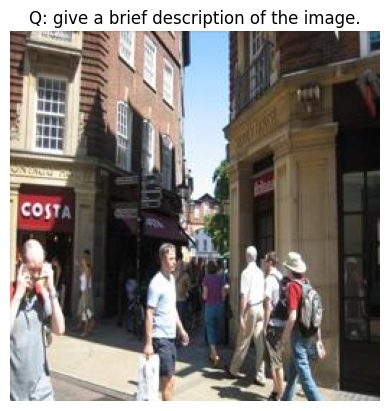

give a bri e f des cri pt ion of the image . a man in a street in a city street
None


In [ ]:
img   =  "/Users/saptarshimallikthakur/Desktop/Extraas/Towards VLM/VLM/GQA/resized_images/736.jpg"
ques  = "give a brief description of the image."
print(generate_answer(img, ques))

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 259, 299, 72, 617, 1037, 33, 4, 72, 617, 299, 1435, 52, 18, 3]


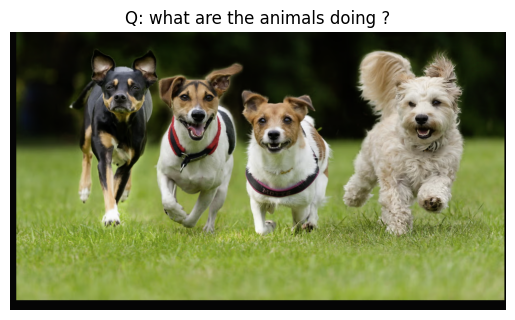

what are the animals doing ? the animals are cow s .
None


In [ ]:
img   =  "/Users/saptarshimallikthakur/Desktop/Screenshot 2025-07-22 at 6.48.39 AM.png"
ques  = "what are the animals doing ?"
print(generate_answer(img, ques))

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 259, 93, 72, 543, 1037, 33, 4, 72, 543, 93, 1216, 18, 3]


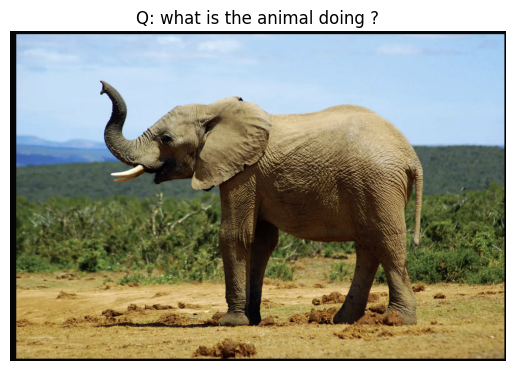

what is the animal doing ? the animal is eating .
None


In [ ]:
img   =  "/Users/saptarshimallikthakur/Desktop/Screenshot 2025-07-22 at 6.52.00 AM.png"
ques  = "what is the animal doing ?"
print(generate_answer(img, ques))

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 259, 93, 72, 244, 594, 52, 126, 72, 776, 33, 4, 72, 776, 93, 1417, 18, 3]


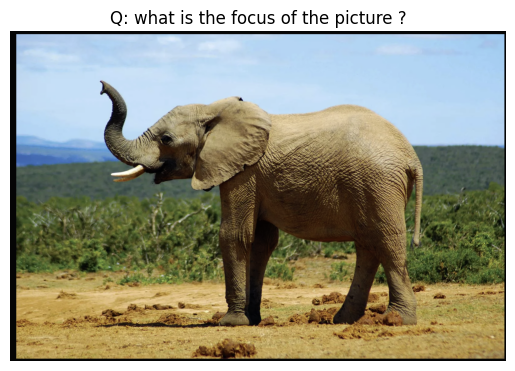

what is the fo cu s of the picture ? the picture is elephant .
None


In [ ]:
img   =  "/Users/saptarshimallikthakur/Desktop/Screenshot 2025-07-22 at 6.52.00 AM.png"
ques  = "what is the focus of the picture ?"
print(generate_answer(img, ques))

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 259, 93, 72, 1745, 126, 1417, 33, 4, 72, 1417, 93, 1417, 18, 3]


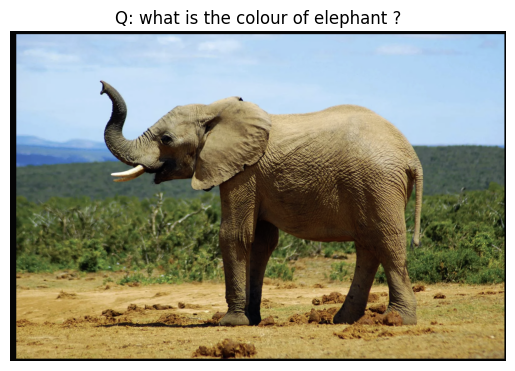

what is the colour of elephant ? the elephant is elephant .
None


In [ ]:
img   =  "/Users/saptarshimallikthakur/Desktop/Screenshot 2025-07-22 at 6.52.00 AM.png"
ques  = "what is the colour of elephant ?"
print(generate_answer(img, ques))

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 259, 200, 157, 311, 33, 4, 72, 436, 93, 1063, 88, 18, 3]


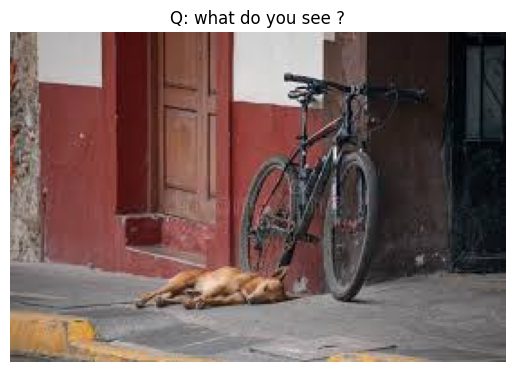

what do you see ? the dog is cover ing .
None


In [ ]:
img   =  "/Users/saptarshimallikthakur/Desktop/dog sleeping.jpeg"
ques  = "what do you see ?"
print(generate_answer(img, ques))

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 415, 623, 2678, 299, 160, 76, 72, 3688, 33, 4, 21, 1563, 93, 76, 72, 3688, 18, 3]


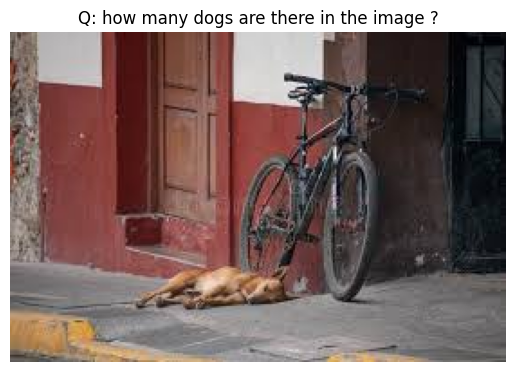

how many dogs are there in the image ? 1 person is in the image .
None


In [ ]:
img   =  "/Users/saptarshimallikthakur/Desktop/dog sleeping.jpeg"
ques  = "how many dogs are there in the image ?"
print(generate_answer(img, ques))

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 259, 93, 72, 436, 1037, 33, 4, 72, 436, 93, 434, 391, 1272, 88, 18, 3]


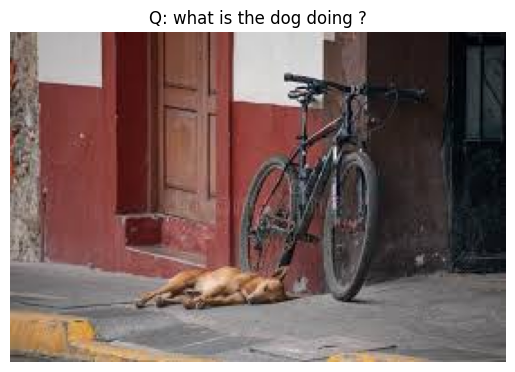

what is the dog doing ? the dog is sk ate board ing .
None


In [ ]:
img   =  "/Users/saptarshimallikthakur/Desktop/dog sleeping.jpeg"
ques  = "what is the dog doing ?"
print(generate_answer(img, ques))